In [1]:
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(ggplot2)
library(tidyr)
library(dplyr)
library(ggrepel)  # For non-overlapping text labels
library(org.Hs.eg.db)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
deseq_brain = readRDS('../../rds/deseq2_brain_mockvirus.rds')
deseq_gundiff = readRDS('../../rds/deseq2_gut_undiff_mockvirus.rds')
deseq_gdiff = readRDS('../../rds/deseq2_gut_diff_mockvirus.rds')
genes = read.csv('../../output/gut/gut_genes.csv',row.names = 1)

In [3]:
deseq = c(deseq_brain,deseq_gundiff,deseq_gdiff)
deseq_meta = data.frame(
    tissue = rep(c('Brain','Gut Undiff','Gut Diff'),each=3),
    virus  = names(deseq)
)
rownames(deseq_meta) = names(deseq) = paste0(deseq_meta$tissue,'-',deseq_meta$virus)
deseq_meta

,tissue,virus
,<chr>,<chr>
Brain-MLB2,Brain,MLB2
Brain-VA1,Brain,VA1
Brain-HAstV4,Brain,HAstV4
Gut Undiff-MLB2,Gut Undiff,MLB2
Gut Undiff-VA1,Gut Undiff,VA1
Gut Undiff-HAstV4,Gut Undiff,HAstV4
Gut Diff-MLB2,Gut Diff,MLB2
Gut Diff-VA1,Gut Diff,VA1
Gut Diff-HAstV4,Gut Diff,HAstV4


In [28]:
plotPair = function(xcnd,ycnd,xlab,ylab,title,top_label_n =20,pv_thr=0.05,l2fc_thr=1,lim=12,gene_names=genes){
    # Build a data frame
    cmn <- intersect(rownames(xcnd), rownames(ycnd))
    
    plot_df <- data.frame(
      gene_id = cmn,
      x = xcnd[cmn, "log2FoldChange"],
      y = ycnd[cmn, "log2FoldChange"],
      xpadj = xcnd[cmn, "padj"],
      ypadj = ycnd[cmn, "padj"]
    )
    
    # Add gene names
    plot_df$gene_name <- gene_names[plot_df$gene_id, "gene_name"]
    
    # Define significance and label criteria
    cols = setNames(c('gray','blue','green','red'),c('none',xlab,ylab,'both'))
    
    sgnx = abs(plot_df$x)>=l2fc_thr & plot_df$xpadj <= pv_thr
    sgnx[is.na(sgnx)] = FALSE
    sgny = abs(plot_df$y)>=l2fc_thr & plot_df$ypadj <= pv_thr
    sgny[is.na(sgny)] = FALSE
    plot_df$significant = 'none'
    plot_df$significant[sgnx] = xlab
    plot_df$significant[sgny] = ylab
    plot_df$significant[sgnx & sgny] = 'both'
    plot_df$significant = factor(plot_df$significant,levels=names(cols))
    sgn_ord = setNames(0:4,c('none',xlab,ylab,'both'))
    plot_df = plot_df[order(sgn_ord[plot_df$significant]),]

    both = plot_df[plot_df$significant=='both',]
    both = both$gene_id[order(abs(both$x)+abs(both$y),decreasing = TRUE)][seq_len(top_label_n)]
    
    gid2label = c(plot_df$gene_id[order(abs(plot_df$x),decreasing = TRUE)[seq_len(top_label_n)]],
                  plot_df$gene_id[order(abs(plot_df$y),decreasing = TRUE)[seq_len(top_label_n)]],
                  both
                 )
    
      plot_df$label <- ifelse(
      plot_df$gene_id %in% gid2label,
      plot_df$gene_name,''
    )
    
    # Plot
    p <- ggplot(plot_df, aes(x = x, y = y,color=significant)) +
      geom_point(shape = 16, size = 2) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
      geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
      geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
      geom_text_repel(aes(label = label), size = 2.5, color = "blue", max.overlaps = Inf) +
      scale_x_continuous(limits = c(-lim, lim)) +
      scale_y_continuous(limits = c(-lim, lim)) +
      theme_minimal() +
      scale_color_manual(values = cols) + 
      labs(
        title = title,
        x = xlab,
        y = ylab,
      )
}

In [29]:
lim = 12
tissues = c('Gut Diff','Gut Undiff','Brain')
viruses = c('HAstV4','MLB2','VA1')


virus_pairs = combn(c('HAstV4','MLB2','VA1'),2)

plot_cmp_v = list()
for(t in tissues){
    for(v in 1:ncol(virus_pairs)){
        p = plotPair(xcnd = deseq[[paste0(t,'-',virus_pairs[1,v])]],
                     ycnd = deseq[[paste0(t,'-',virus_pairs[2,v])]],
                     xlab = virus_pairs[1,v], ylab = virus_pairs[2,v],
                     title = t,
                     lim=lim)
        plot_cmp_v[[length(plot_cmp_v)+1]] = p
    }
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text_repel()`).”


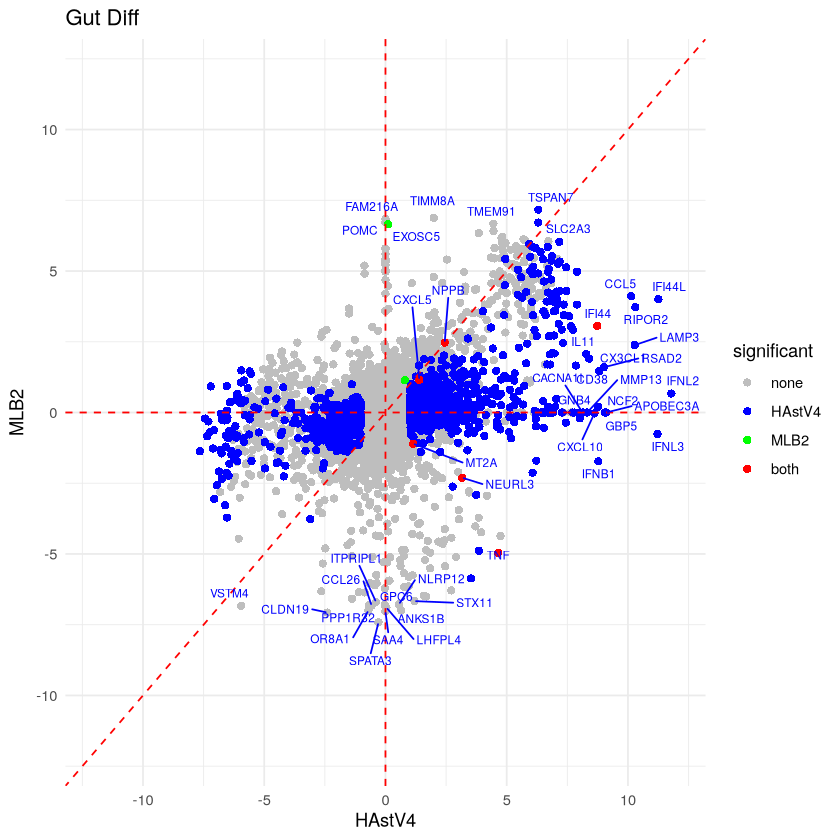

In [30]:
plot_cmp_v[[1]]
ggsave("plotpair_Gdiff_MLB2_vs_HAstV4_top20.png", p, width = 15, height = 12)

In [19]:
library(cowplot)
p = plot_grid(plotlist = plot_cmp_v, nrow = 3, ncol = 3)
ggsave("virus_pairs.pdf", p, width = 15, height = 12)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text_repel()`).”


In [ ]:
p = plotPair(xcnd = deseq_gundiff$HAstV4,
             ycnd = deseq_gundiff$MLB2,
             xlab = "HAstV4", ylab = "MLB2",
             title = "Gut Undiff",
            sgnby='xy',lim=lim)
p
# Save wide plot if needed
ggsave("plotpair_Gundiff_HAstV4_vs_MLB2.pdf", p, width = 4, height = 4)

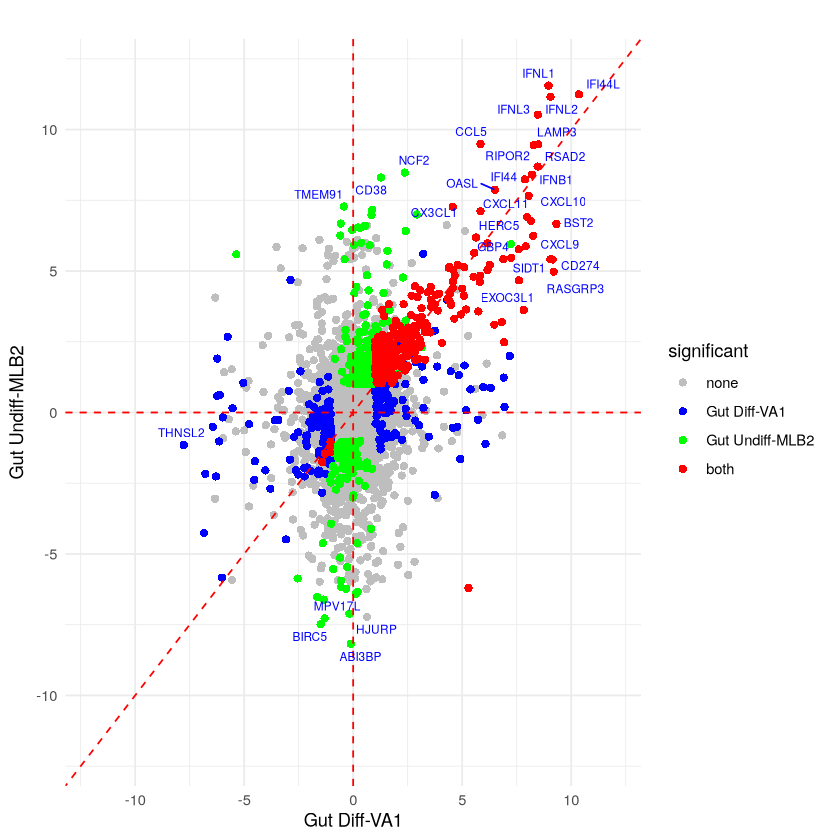

In [40]:
p = plotPair(xcnd = deseq$`Gut Undiff-HAstV4`,
             ycnd = deseq$`Gut Diff-VA1`,
                     xlab = 'Gut Diff-VA1', ylab = 'Gut Undiff-MLB2',
                     title = '',
                     lim=lim)
p